In [1]:
import os
import sys
import argparse
import cv2
import time
import torch
from vidgear.gears import CamGear
import numpy as np

# HRNet Directory
sys.path.append(os.path.abspath('simple-HigherHRNet'))

# Import the required HRNet model classes and utilities
from SimpleHigherHRNet import SimpleHigherHRNet
from misc.visualization import draw_points, draw_skeleton, draw_points_and_skeleton, joints_dict, check_video_rotation
from misc.utils import find_person_id_associations

Image loaded successfully.


c:\Users\rensl\Documents\Final_Project\simple-HigherHRNet\SimpleHigherHRNet.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, ma

device: 'cuda' - 1 GPU(s) will be used
Model initialized successfully.
No joints detected.


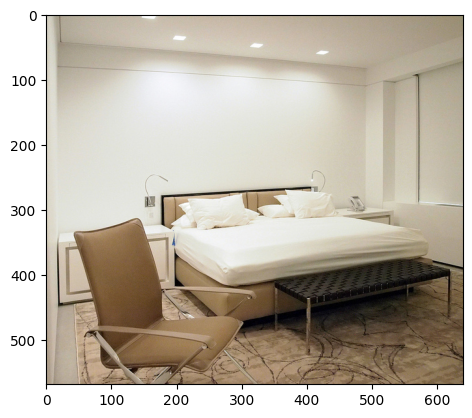

In [3]:
import cv2
import torch
from SimpleHigherHRNet import SimpleHigherHRNet
from misc.visualization import draw_points_and_skeleton, joints_dict
import matplotlib.pyplot as plt

# Load the image
image_path = "data/coco/images/test2017/000000001194.jpg"
image = cv2.imread(image_path)

# Check if the image was loaded correctly
if image is None:
    raise ValueError(f"Image at path '{image_path}' could not be loaded. Please check the path.")

print("Image loaded successfully.")

# Initialize the model
model = SimpleHigherHRNet(
    c=32,
    nof_joints=17,
    checkpoint_path="simple-HigherHRNet/weights/pose_higher_hrnet_w32_512.pth",
    resolution=512,
    return_bounding_boxes=False,
    max_nof_people=30,
    max_batch_size=16,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

print("Model initialized successfully.")

# Perform pose estimation
joints = model.predict(image)

# Check if joints were detected
if len(joints) == 0:
    print("No joints detected.")
else:
    print(f"Detected joints for {len(joints)} people.")

# Draw the keypoints and skeleton on the image
if len(joints) > 0:
    skeleton = joints_dict()['coco']['skeleton']
    image = draw_points_and_skeleton(image, joints[0], skeleton, points_color_palette='gist_rainbow', skeleton_color_palette='jet')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image with keypoints and skeleton
cv2.imshow("Pose Estimation", image)
plt.imshow(image_rgb)
cv2.waitKey(0)
cv2.destroyAllWindows()

opening camera

In [4]:
import cv2
import torch
from SimpleHigherHRNet import SimpleHigherHRNet
from misc.visualization import draw_points_and_skeleton, joints_dict

# Initialize the model
model = SimpleHigherHRNet(
    c=32,
    nof_joints=17,
    checkpoint_path="simple-HigherHRNet/weights/pose_higher_hrnet_w32_512.pth",
    resolution=512,
    return_bounding_boxes=False,
    max_nof_people=30,
    max_batch_size=16,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

print("Model initialized successfully.")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

print("Camera opened successfully.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read frame.")
        break

    joints = model.predict(frame)

    if len(joints) > 0:
        skeleton = joints_dict()['coco']['skeleton']
        frame = draw_points_and_skeleton(frame, joints[0], skeleton, points_color_palette='gist_rainbow', skeleton_color_palette='jet')

    cv2.imshow("Pose Estimation", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


device: 'cuda' - 1 GPU(s) will be used
Model initialized successfully.
Camera opened successfully.
Error: Could not read frame.


In [5]:
import cv2
import numpy as np
import os
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from SimpleHigherHRNet import SimpleHigherHRNet

# Adjust this to your actual base path
base_path = "data/coco"
image_folder = os.path.join(base_path, "images/val2017")

# Check if the image folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Image folder not found: {image_folder}")

# Initialize HigherHRNet model
model = SimpleHigherHRNet(
    c=32,
    nof_joints=17,
    checkpoint_path="simple-HigherHRNet/weights/pose_higher_hrnet_w32_512.pth",
    resolution=512,
    return_bounding_boxes=False,
    max_nof_people=30,
    max_batch_size=16,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    image_height, image_width, _ = image.shape
    joints = model.predict(image)
    
    if len(joints) == 0:
        return None

    # We'll just use the first person detected for simplicity
    person_joints = joints[0]
    
    coco_keypoints = []
    x_coords = []
    y_coords = []
    for x, y, confidence in person_joints:
        x_pixel = int(x * image_width)
        y_pixel = int(y * image_height)
        coco_keypoints.extend([x_pixel, y_pixel, 2 if confidence > 0.1 else 0])
        if confidence > 0.1:
            x_coords.append(x_pixel)
            y_coords.append(y_pixel)
    
    if x_coords and y_coords:
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        width = x_max - x_min
        height = y_max - y_min
        bbox = [x_min, y_min, width, height]
    else:
        bbox = [0, 0, 0, 0]
    
    return coco_keypoints, bbox if len(coco_keypoints) == 51 else None

# Process COCO dataset
coco = COCO(os.path.join(base_path, 'annotations/person_keypoints_val2017.json'))
results = []
processed_count = 0
skipped_count = 0

for img_id in coco.getImgIds():  # Limiting to the first 50 images
    img_info = coco.loadImgs(img_id)[0]
    image_path = os.path.join(image_folder, img_info['file_name'])
    if os.path.exists(image_path):
        print(f"Processing image: {image_path}")
        result = process_image(image_path)
        if result:
            keypoints, bbox = result
            result = {
                'image_id': img_id,
                'category_id': 1,  # person category
                'keypoints': keypoints,
                'bbox': bbox,
                'score': np.mean([kp for i, kp in enumerate(keypoints) if i % 3 == 2])  # average confidence
            }
            results.append(result)
            processed_count += 1
    else:
        print(f"Image not found: {image_path}")
        skipped_count += 1

print(f"Total images processed: {processed_count}")
print(f"Total images skipped (not found): {skipped_count}")

# Print a sample result
if results:
    print("Sample result:")
    print(results[0])
    print("Number of keypoints:", len(results[0]['keypoints']))
    print("First few keypoints:", results[0]['keypoints'][:6])
    print("Bounding box:", results[0]['bbox'])

# Evaluate
if results:
    coco_dt = coco.loadRes(results)
    coco_eval = COCOeval(coco, coco_dt, 'keypoints')
    coco_eval.params.imgIds = [r['image_id'] for r in results]  # Only evaluate on processed images
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    print(f"AP: {coco_eval.stats[0]}")
    print(f"AP.5: {coco_eval.stats[1]}")
    print(f"AP.75: {coco_eval.stats[2]}")
    print(f"AP (M): {coco_eval.stats[3]}")
    print(f"AP (L): {coco_eval.stats[4]}")
else:
    print("No results to evaluate. Check if any images were successfully processed.")

device: 'cuda' - 1 GPU(s) will be used
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
Processing image: data/coco\images/val2017\000000397133.jpg
Processing image: data/coco\images/val2017\000000037777.jpg
Processing image: data/coco\images/val2017\000000252219.jpg
Processing image: data/coco\images/val2017\000000087038.jpg
Processing image: data/coco\images/val2017\000000174482.jpg
Processing image: data/coco\images/val2017\000000403385.jpg
Processing image: data/coco\images/val2017\000000006818.jpg
Processing image: data/coco\images/val2017\000000480985.jpg
Processing image: data/coco\images/val2017\000000458054.jpg
Processing image: data/coco\images/val2017\000000331352.jpg
Processing image: data/coco\images/val2017\000000296649.jpg
Processing image: data/coco\images/val2017\000000386912.jpg
Processing image: data/coco\images/val2017\000000502136.jpg
Processing image: data/coco\images/val2017\000000491497.jpg
Processing image: data/coco\images/val

In [ ]:
import cv2
import numpy as np
import os
import torch
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from SimpleHigherHRNet import SimpleHigherHRNet

# Adjust this to your actual base path
base_path = "data/coco"
image_folder = os.path.join(base_path, "images/val2017")

# Check if the image folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"Image folder not found: {image_folder}")

# Initialize HigherHRNet model
model = SimpleHigherHRNet(
    c=32,
    nof_joints=17,
    checkpoint_path="simple-HigherHRNet/weights/pose_higher_hrnet_w32_512.pth",
    resolution=512,
    return_bounding_boxes=False,
    max_nof_people=30,
    max_batch_size=16,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image: {image_path}")
        return None
    image_height, image_width, _ = image.shape
    joints = model.predict(image)
    
    if len(joints) == 0:
        return None

    # We'll just use the first person detected for simplicity
    person_joints = joints[0]
    
    coco_keypoints = []
    x_coords = []
    y_coords = []
    for x, y, confidence in person_joints:
        x_pixel = int(x * image_width)
        y_pixel = int(y * image_height)
        coco_keypoints.extend([x_pixel, y_pixel, 2 if confidence > 0.1 else 0])
        if confidence > 0.1:
            x_coords.append(x_pixel)
            y_coords.append(y_pixel)
    
    if x_coords and y_coords:
        x_min, x_max = min(x_coords), max(x_coords)
        y_min, y_max = min(y_coords), max(y_coords)
        width = x_max - x_min
        height = y_max - y_min
        bbox = [x_min, y_min, width, height]
    else:
        bbox = [0, 0, 0, 0]
    
    return coco_keypoints, bbox if len(coco_keypoints) == 51 else None

# Process COCO dataset
coco = COCO(os.path.join(base_path, 'annotations/person_keypoints_val2017.json'))
results = []
processed_count = 0
skipped_count = 0

for img_id in coco.getImgIds()[:50]:  # Limiting to the first 50 images
    img_info = coco.loadImgs(img_id)[0]
    image_path = os.path.join(image_folder, img_info['file_name'])
    if os.path.exists(image_path):
        print(f"Processing image: {image_path}")
        result = process_image(image_path)
        if result:
            keypoints, bbox = result
            result = {
                'image_id': img_id,
                'category_id': 1,  # person category
                'keypoints': keypoints,
                'bbox': bbox,
                'score': np.mean([kp for i, kp in enumerate(keypoints) if i % 3 == 2])  # average confidence
            }
            results.append(result)
            processed_count += 1
    else:
        print(f"Image not found: {image_path}")
        skipped_count += 1

print(f"Total images processed: {processed_count}")
print(f"Total images skipped (not found): {skipped_count}")

# Print a sample result
if results:
    print("Sample result:")
    print(results[0])
    print("Number of keypoints:", len(results[0]['keypoints']))
    print("First few keypoints:", results[0]['keypoints'][:6])
    print("Bounding box:", results[0]['bbox'])

# Evaluate
if results:
    coco_dt = coco.loadRes(results)
    coco_eval = COCOeval(coco, coco_dt, 'keypoints')
    coco_eval.params.imgIds = [r['image_id'] for r in results]  # Only evaluate on processed images
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    print(f"AP: {coco_eval.stats[0]}")
    print(f"AP.5: {coco_eval.stats[1]}")
    print(f"AP.75: {coco_eval.stats[2]}")
    print(f"AP (M): {coco_eval.stats[3]}")
    print(f"AP (L): {coco_eval.stats[4]}")
else:
    print("No results to evaluate. Check if any images were successfully processed.")